In [1]:
# import required libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import gzip

from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split

In [2]:
# url text dataset from amazon about software review
dataset_url = 'https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Software_v1_00.tsv.gz'

In [3]:
# download dataset file from url
# fname represent filename of downloaded file
# extract false keep the downloaded file un-extracted
dataset_dir = utils.get_file(fname='amazon_reviews_us_Software_v1_00.tsv.gz', origin=dataset_url, cache_subdir='amazon', extract=False, cache_dir='/content/')

94011392/94010685 [==============================] - 3s 0us/step


In [4]:
# open donwloaded dataset file in directory with mode read as text (rt)
file = gzip.open(dataset_dir, mode='rt')

# read opened file as csv with delimiter tab (\t)
# ignore row with null column, some of row have null column
# set low of memory to false to avoid out of memory when read large file 
csv_ds = pd.read_csv(file, sep='\t', error_bad_lines=False, skip_blank_lines=True, low_memory=False)

b'Skipping line 8021: expected 15 fields, saw 22\nSkipping line 34886: expected 15 fields, saw 22\nSkipping line 49286: expected 15 fields, saw 22\n'


In [5]:
# check unique value of star rating. Later this column will be used as label
# 1 = negative
# 2 = negative
# 3 = neutral
# 4 = positive
# 5 = positive
csv_ds['star_rating'].unique()

array([1, 5, 2, 3, 4])

In [6]:
# remove rows with value star_rating neutral. Because neutral rating not required to evaluate positive or negative feedback
csv_ds = csv_ds[csv_ds.star_rating != 3]

In [7]:
# check unique value after remove neutral star rating
csv_ds['star_rating'].unique()

array([1, 5, 2, 4])

In [8]:
# change value of star rating 1 and 2 to -1 as negative label
csv_ds.loc[(csv_ds.star_rating < 3), 'star_rating'] = -1

# change value of star rating 4 and 5 to 1 as positive label
csv_ds.loc[(csv_ds.star_rating > 3), 'star_rating'] = 1

In [9]:
# check unique value after remove neutral star rating
csv_ds['star_rating'].unique()

array([-1,  1])

In [10]:
# check total number of testing data before drop rows
len(csv_ds)

310610

In [11]:
# count null value in review_body column
csv_ds['review_body'].isnull().sum()

2

In [12]:
# remove rows with column review_body is null
csv_ds.dropna(subset=["review_body"], inplace=True)

In [13]:
# count null value in star_rating column
csv_ds['star_rating'].isnull().sum()

0

In [14]:
# check total number of testing data after drop rows
len(csv_ds)

310608

In [15]:
# check dataset value
csv_ds.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,42605767,R3EFW2STIYIY0I,B00MUTIDKI,248732228,McAfee 2015 Internet Security 3 PC (3-Users),Software,-1,2,2,N,Y,I was very disappointed with this,I was very disappointed with this. The descrip...,2015-08-31
1,US,51771800,R12NR0R5A9F7FT,B00EPACNUG,531462352,Hallmark Card Studio 2014,Software,1,0,0,N,Y,Five Stars,"I had a little struggle getting familiarized, ...",2015-08-31
2,US,16053526,R1LSH74R9XAP59,B00164AZA4,473982505,Search and Rescue 4,Software,-1,0,1,N,Y,Have windows 10?,Tried to download it on my Windows 10 and it w...,2015-08-31
3,US,15319481,R1QXUNTF76K7L6,B00E6LIEFM,189774198,Quickbooks Pro,Software,-1,0,0,N,Y,"Disc was corrupt, had to spend a couple hours ...","Disc was corrupt, had to spend a couple hours ...",2015-08-31
4,US,1441820,R2F7DR75PS8NKT,B00VWEBG06,852470365,Windows 7 Professional with Service Pack 1 (64...,Software,1,0,0,N,Y,Five Stars,Just what I needed. Took a little longer to sh...,2015-08-31


In [16]:
# check info of dataset
csv_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310608 entries, 0 to 341247
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        310608 non-null  object
 1   customer_id        310608 non-null  int64 
 2   review_id          310608 non-null  object
 3   product_id         310608 non-null  object
 4   product_parent     310608 non-null  int64 
 5   product_title      310608 non-null  object
 6   product_category   310608 non-null  object
 7   star_rating        310608 non-null  int64 
 8   helpful_votes      310608 non-null  int64 
 9   total_votes        310608 non-null  int64 
 10  vine               310608 non-null  object
 11  verified_purchase  310608 non-null  object
 12  review_headline    310605 non-null  object
 13  review_body        310608 non-null  object
 14  review_date        310601 non-null  object
dtypes: int64(5), object(10)
memory usage: 37.9+ MB


In [17]:
# split dataset for 80% training and 20 % testing with random 500
ds_train, ds_test = train_test_split(csv_ds, test_size=0.2, random_state=500)

In [18]:
# check total number of training data
len(ds_train)

248486

In [19]:
# check total number of testing data
len(ds_test)

62122

In [20]:
# check training dataset value
ds_train.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
161542,US,47123672,RBXV810CA12G5,B0000E6NK9,317968513,Mac OS X 10.3 Panther [OLD VERSION],Software,-1,0,1,N,Y,Worse experience I have had on Amazon,This was the worse experience I have had on Am...,2013-01-23
113131,US,16552426,R3JJTF4LC9S9GZ,B003VNCRR2,60765083,Dragon NaturallySpeaking Premium 11 Student Ed...,Software,1,0,0,N,Y,Pleased but buy the more recent edition!,"Bought this and was pleased, but the newer edi...",2013-12-12
293425,US,20487259,REALE5VIFZAV2,B000LJYUW4,137924946,iolo System Mechanic 7 Professional - 3 PCs,Software,-1,6,6,N,N,"Finally, I understand!","I formatted my laptop last Tuesday, and after ...",2007-01-19
275234,US,15819410,R2GIYBDMW7F8X6,B000O5X8XW,17369334,Nintendo Wii Play Game Only,Software,-1,0,0,N,N,Why Bother?,It's perhaps worthwhile getting this if you bu...,2008-03-16
272178,US,13097980,RUCJF8ODJJVFY,B000I2BEUA,819158002,Starry Night Complete Space & Astronomy Pack [...,Software,1,0,6,N,Y,Retired Pro photographer,I like the manfrotto mono pod. It os light wei...,2008-05-25


In [21]:
# check testing dataset value
ds_test.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
270060,US,15392054,R34Q169Y0XJQD0,B000UKBIEC,726221483,Adobe Photoshop Elements 6 - Old Version,Software,1,3,5,N,N,Hate the gray,"I have used Elements 2.0, 4.0 and PS CS2. My f...",2008-07-19
180639,US,17025875,R2WGHOUL0G2KXE,B005MMMT0A,849167509,Adobe Photoshop Elements & Premiere Elements 10,Software,1,0,1,N,Y,So excited for this!,After taking a class on Photoshop using 10 I w...,2012-07-28
340973,US,50275414,R2SVBVMM3E00RU,B00003IELZ,295944809,Richard Scarry's Busytown,Software,-1,11,15,N,N,Richard Scarry's Busytown 200 cd-rom,This is not very educational. My 4 year old fi...,2000-01-12
196504,US,46600273,RR5BLOEX8DUT8,B00321OBJ0,747150927,Norton Antivirus for Mac 11.1 [Old Version],Software,1,0,0,N,N,"Some work, but well worth it!",I've been using Norton Security products since...,2011-11-28
192541,US,20779486,R2SUHQME0QO8ZI,B000023VVY,130680945,Winnie the Pooh Preschool,Software,1,0,0,N,N,My daughter loves it and so do I!,I got this for my daughter (2 years 2 months) ...,2012-01-20


In [22]:
# slice dataset to convert from type pandas dataframe to tensorflow dataframe
# if not converted to tensorflow dataset, dataset can't be used on step text vectorization
# column used for evaluate text classfication is review_body
# column used for label of review_body is star_rating
tf_ds_train = (tf.data.Dataset.from_tensor_slices((
    ds_train['review_body'].values,
    ds_train['star_rating'].values))
)

tf_ds_test = (tf.data.Dataset.from_tensor_slices((
    ds_test['review_body'].values,
    ds_test['star_rating'].values))
)

In [23]:
# check training text and label
for example, label in tf_ds_train.take(10):
  print('text train: ', example.numpy())
  print('label train: ', label.numpy())

text train:  b'This was the worse experience I have had on Amazon. This product was nothing the seller said. I would never do business with them again, and Amazon should try to find more about sellers like the person who sold me this product and kick them off the Internet.'
label train:  -1
text train:  b'Bought this and was pleased, but the newer editions are now much more capable and productive and the price is right!'
label train:  1
text train:  b'I formatted my laptop last Tuesday, and after bringing it up I decided to compare SM 7 Pro (luckily for me it was a free demo I was using) and Norton 360.  <br /> <br />Now I understand why: <br />1) Norton found 4 threats even though I had just formatted my computer. <br />2) I wasn\'t able to shutdown my laptop after installing the last \\\\"important upgrade\\\\". <br />3) I kept receiving run-time errors while using the laptop. <br /> <br />I guess I\'ll just stick to V6 and never use the \\\\"amazing offer\\\\" that I see about upgra

In [24]:
# check testing text and label
for example, label in tf_ds_test.take(10):
  print('text test: ', example.numpy())
  print('label test: ', label.numpy())

text test:  b'I have used Elements 2.0, 4.0 and PS CS2. My favorite is 4.0, although I am trying to get used to the changes in 6.0. I HATE the gray background and have not figured out if it can be changed...mainly because there is no manual. It definitely needs a printed manual as it is a royal pain to have to try to find and print the help screens.'
label test:  1
text test:  b'After taking a class on Photoshop using 10 I was so happy get a deal with both Photoshop and Premier Elements. I have used PE at work and love the program, love being able to create movies with this program.<br />Photoshop 10 is great, love removing color from photos to add back in just the touches I want. Surprisingly easy but I do think either a book or class is necessary.<br />I use these programs to create unique gifts for friends and family and also to dress up my photos for around the house.<br />Highly recommend these programs!'
label test:  1
text test:  b'This is not very educational. My 4 year old fin

In [25]:
# shuffle and create batches of text and label for training and testing dataset
BUFFER_SIZE = 10000
BATCH_SIZE = 64

tf_ds_train = tf_ds_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
tf_ds_test = tf_ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [26]:
# check training text and label after shuffle and create batches
for example, label in tf_ds_train.take(1):
  print('texts train: ', example.numpy()[:3])
  print()
  print('labels train: ', label.numpy()[:3])

texts train:  [b"I've used both Ghost 12 and 14 for years. For making a backup to an internal partition and restoring it to the original or new drive partition, I've been quite pleased.     Just be aware that to restore your system partition onto a new drive you first have to create and format the partition using the Windows install disk. It is okay if the target partition is bigger than the original, that is usually the point of a new drive.     Non-system partitions can be formatted using the Windows Disk Management utility in the Control Panel, Administrative Tools, Computer Management section.     I have not tried to use Ghost 14 with a networked drive nor have I tried the Copy my hard Drive function that other reviewers complained about.     The user interface is not as intuitive as older versions. The Home screen does not include the One Time Backup method that I prefer. I found it under the Tasks icon instead. All the funtionality of previous versions is there if you look for it

In [27]:
# check testing text and label after shuffle and create batches
for example, label in tf_ds_test.take(1):
  print('texts test: ', example.numpy()[:3])
  print()
  print('labels test: ', label.numpy()[:3])

texts test:  [b'I have used Elements 2.0, 4.0 and PS CS2. My favorite is 4.0, although I am trying to get used to the changes in 6.0. I HATE the gray background and have not figured out if it can be changed...mainly because there is no manual. It definitely needs a printed manual as it is a royal pain to have to try to find and print the help screens.'
 b'After taking a class on Photoshop using 10 I was so happy get a deal with both Photoshop and Premier Elements. I have used PE at work and love the program, love being able to create movies with this program.<br />Photoshop 10 is great, love removing color from photos to add back in just the touches I want. Surprisingly easy but I do think either a book or class is necessary.<br />I use these programs to create unique gifts for friends and family and also to dress up my photos for around the house.<br />Highly recommend these programs!'
 b'This is not very educational. My 4 year old finds it boring. Most of the program they give you th

In [28]:
# create text vectorization with maximum vocabulary 10000
VOCAB_SIZE = 10000
encoder = TextVectorization(max_tokens=VOCAB_SIZE)

# pass text vectorization encoder to training dataset
encoder.adapt(tf_ds_train.map(lambda text, label: text))

In [29]:
# get vocabulary object
vocab = np.array(encoder.get_vocabulary())

In [30]:
# display 50 vocabulary
vocab[:50]

array(['', '[UNK]', 'the', 'to', 'i', 'and', 'a', 'it', 'of', 'is', 'for',
       'this', 'you', 'that', 'in', 'with', 'my', 'have', 'on', 'br',
       'not', 'was', 'but', 'as', 'software', 'are', 'be', 'so', 'if',
       'all', 'or', 'from', 'use', 'program', 'product', 'can', 'your',
       'me', 'had', 'they', 'an', 'will', 'do', 'very', 'its', 'at',
       'windows', 'one', 'version', 'has'], dtype='<U19')

In [31]:
encoded_example = encoder(example)[0:3].numpy()
encoded_example

array([[  4,  17,  71, ...,   0,   0,   0],
       [ 79, 833,   6, ...,   0,   0,   0],
       [ 11,   9,  20, ...,   0,   0,   0]])

In [32]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I have used Elements 2.0, 4.0 and PS CS2. My favorite is 4.0, although I am trying to get used to the changes in 6.0. I HATE the gray background and have not figured out if it can be changed...mainly because there is no manual. It definitely needs a printed manual as it is a royal pain to have to try to find and print the help screens.'
Round-trip:  i have used elements 20 40 and ps cs2 my favorite is 40 although i am trying to get used to the changes in 60 i hate the gray background and have not figured out if it can be [UNK] because there is no manual it definitely needs a printed manual as it is a royal pain to have to try to find and print the help screens                                                                                                                                                                                                                                                                                                                               

In [33]:
# create RNN model with layers LSTM 128 (first) and 64 (second) unit and return_sequences=True to continue the output as an input of second Bidirectional layer
model = tf.keras.Sequential([
    encoder,
    layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [34]:
# evaluate positive prediction of feedback before training
good_feeback = ('This application experience great, UI friendly, the animation were amazing and totally different with others.'
                'Thumbs up for the team.')
predictions = model.predict(np.array([good_feeback]))
print(predictions[0])

[-0.00239479]


In [35]:
# evaluate positive prediction of feedback with padding before training
padding = "the " * 2000
predictions = model.predict(np.array([good_feeback, padding]))
print(predictions[0])

[-0.00239479]


In [36]:
# evaluate negative prediction of feedback before training
bad_feeback = ('Give back my money!! Don\'t purchase this app')
predictions = model.predict(np.array([bad_feeback]))
print(predictions[0])

[-0.00119166]


In [37]:
# evaluate negative prediction of feedback with padding before training
padding = "the " * 2000
predictions = model.predict(np.array([bad_feeback, padding]))
print(predictions[0])

[-0.00119166]


In [38]:
# compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [39]:
# training process
history = model.fit(tf_ds_train, epochs=10,
                    validation_data=tf_ds_test,
                    validation_steps=30)

Epoch 1/10
3883/3883 [==============================] - 795s 202ms/step - loss: -74.9832 - accuracy: 0.5368 - val_loss: -225.3182 - val_accuracy: 0.5943
Epoch 2/10
3883/3883 [==============================] - 858s 221ms/step - loss: -416.0996 - accuracy: 0.5691 - val_loss: -737.7991 - val_accuracy: 0.5594
Epoch 3/10
3883/3883 [==============================] - 829s 212ms/step - loss: -1137.4213 - accuracy: 0.5925 - val_loss: -1543.2245 - val_accuracy: 0.5552
Epoch 4/10
3883/3883 [==============================] - 853s 220ms/step - loss: -1918.6337 - accuracy: 0.5892 - val_loss: -2395.1196 - val_accuracy: 0.5469
Epoch 5/10
3883/3883 [==============================] - 783s 202ms/step - loss: -3109.6372 - accuracy: 0.6144 - val_loss: -3754.6313 - val_accuracy: 0.6120
Epoch 6/10
3883/3883 [==============================] - 805s 207ms/step - loss: -4687.1636 - accuracy: 0.6113 - val_loss: -5685.1582 - val_accuracy: 0.6036
Epoch 7/10
3883/3883 [==============================] - 791s 204ms/st

In [40]:
# evaluate accuracy after training process
test_loss, test_acc = model.evaluate(tf_ds_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

971/971 [==============================] - 81s 84ms/step - loss: -10759.4150 - accuracy: 0.5605
Test Loss: -10759.4150390625
Test Accuracy: 0.5605260729789734


(0.0, 498.9573379516602)

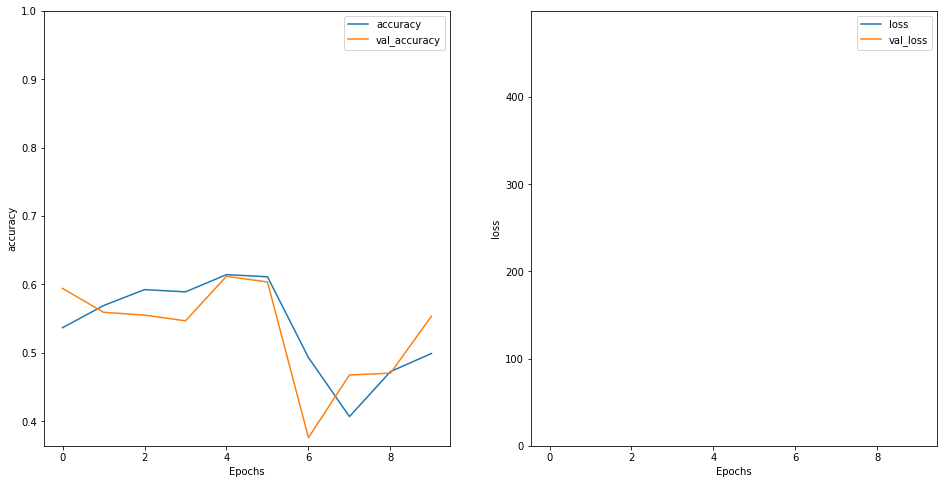

In [41]:
# chart accuracy
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [42]:
# evaluate positive prediction of feedback after training
predictions = model.predict(np.array([good_feeback]))
print(predictions[0])

[57.51057]


In [43]:
# evaluate negative prediction of feedback after training
predictions = model.predict(np.array([bad_feeback]))
print(predictions[0])

[-59871.176]
